# Exploratory Data Analysis: Trip Duration

- id: a unique identifier for each trip
- vendor_id: a code indicating the provider associated with the trip record
- pickup_datetime: date and time when the meter was engaged
- dropoff_datetime: date and time when the meter was disengaged
- passenger_count: the number of passengers in the vehicle (driver entered value)
- pickup_longitude: the longitude where the meter was engaged
- pickup_latitude: the latitude where the meter was engaged
- dropoff_longitude: the longitude where the meter was disengaged
- dropoff_latitude: the latitude where the meter was disengaged
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- trip_duration: duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the train set.

In [1]:
%%time

# Import Standard Libraries
import os
import sys
import warnings
# warnings.filterwarnings("ignore")

# Import Data Handling Libraries
import pandas as pd
import numpy as np
np.random.seed(42)

# Import Date-Time Handling Libraries
from datetime import timedelta
import datetime as dt

# Import Geodetic Libraries
import pyproj
from pyproj import Geod

# Import Data Visualization Libraries
import matplotlib
matplotlib.rcParams["font.size"] = 12
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 12]  # Set default figure size
import seaborn as sns

# Import Map Utilities
import folium
from folium.plugins import MarkerCluster

# Import Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.cluster import MiniBatchKMeans  # Clustering algorithm for large datasets
from scipy.stats import zscore

# Set random seed for reproducibility in scikit-learn
from sklearn.utils import check_random_state
rng = check_random_state(42)

# Import Utilities
import gc
from tqdm import tqdm
import joblib

# Import Custom Modules
from data_loader import *  # Custom data loading functions

CPU times: user 3.57 s, sys: 1.01 s, total: 4.58 s
Wall time: 4.76 s


In [2]:
%%time

# Genrate directories for utils outcome genrated
os.makedirs("images", exist_ok=True)

CPU times: user 68 µs, sys: 20 µs, total: 88 µs
Wall time: 103 µs


In [3]:
%%time

# Configure color palettes
colors_b = sns.color_palette(palette="GnBu", n_colors=6)

CPU times: user 9.56 ms, sys: 391 µs, total: 9.95 ms
Wall time: 9.57 ms


In [4]:
%%time

# Load the dataset
data = pd.read_csv(
    os.path.join(os.getcwd(), "data", "data.csv")
)
data.head()

CPU times: user 3.37 s, sys: 1.1 s, total: 4.47 s
Wall time: 4.96 s


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
%%time

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
CPU times: user 204 ms, sys: 7.41 ms, total: 211 ms
Wall time: 209 ms


In the given Kaggle competition, ground truth labels are only provided for the training dataset, while the test dataset lacks publicly available labels. As a result, for the STDM project, the training dataset is exlusively leveraged for model development, evaluation, and analysis. Without access to the test labels, we focus on techniques such as cross-validation and train-validation splits to assess model performance effectively.

## Validating Dataset Integrity & Quality

In [6]:
%%time

# Ensure `pickup_datetime` and `dropoff_datetime` are in datetime format
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
data["dropoff_datetime"] = pd.to_datetime(data["dropoff_datetime"])

# Check if dropoff_datetime - pickup_datetime equals trip_duration (in seconds) for each record
assert all((data["dropoff_datetime"] - data["pickup_datetime"]).dt.total_seconds() == data["trip_duration"]), \
    "The difference between dropoff_datetime and pickup_datetime should equal the trip_duration for each record."

# Check if id is unique
assert data["id"].is_unique, "id column should contain unique values."

# Check if store_and_fwd_flag contains only 2 kinds of variables
assert set(data["store_and_fwd_flag"].unique()).issubset({"Y", "N"}), "store_and_fwd_flag should contain only `Y` and `N` values."

# Check there are no missing values
assert not data.isnull().values.any(), "Dataset contains missing values!"

# Print success message if all checks pass
print("All checks validating dataset integrity & quality passed successfully!")

All checks validating dataset integrity & quality passed successfully!
CPU times: user 1.28 s, sys: 38.4 ms, total: 1.32 s
Wall time: 1.32 s


## Overview Data Distribution

In [7]:
%%time

# View unique values of selected columns
unique_values = {col: data[col].unique() for col in [
    "vendor_id", "passenger_count", 
    "store_and_fwd_flag", "trip_duration"]}
unique_values

CPU times: user 77.6 ms, sys: 0 ns, total: 77.6 ms
Wall time: 75.6 ms


{'vendor_id': array([2, 1]),
 'passenger_count': array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8]),
 'store_and_fwd_flag': array(['N', 'Y'], dtype=object),
 'trip_duration': array([  455,   663,  2124, ..., 11513, 72504,  6124])}

In [8]:
%%time

# View mean and median for passenger_count and trip_duration
stats = {
    "passenger_count": {
        "min": data["passenger_count"].min(),
        "mean": data["passenger_count"].mean(),
        "median": data["passenger_count"].median(),
        "max": data["passenger_count"].max(),
    },
    "trip_duration": {
        "min": data["passenger_count"].min(),
        "mean": data["trip_duration"].mean(),
        "median": data["trip_duration"].median(),
        "max": data["trip_duration"].max(),
    }
}
stats

CPU times: user 57.4 ms, sys: 6.22 ms, total: 63.6 ms
Wall time: 61.4 ms


{'passenger_count': {'min': 0,
  'mean': 1.6645295219395548,
  'median': 1.0,
  'max': 9},
 'trip_duration': {'min': 0,
  'mean': 959.4922729603659,
  'median': 662.0,
  'max': 3526282}}

Observation:

- `vendor_id` only takes values `1` or `2`, likely distinguishing two taxi companies. It can be safely converted into a binary categorical variable.  
- `passenger_count` has a median of 1 and a maximum of 9.  
- `store_and_fwd_flag` indicates whether trip data was sent to the vendor immediately (`"N"`) or temporarily stored due to a lack of connection (`"Y"`). This may correlate with certain geographical areas that have poor reception.  
- `trip_duration` is typically between 10 to 15 minutes. Trips shorter than 1 minute or longer than 100 hours are likely outliers.

store_and_fwd_flag_Y_pickup


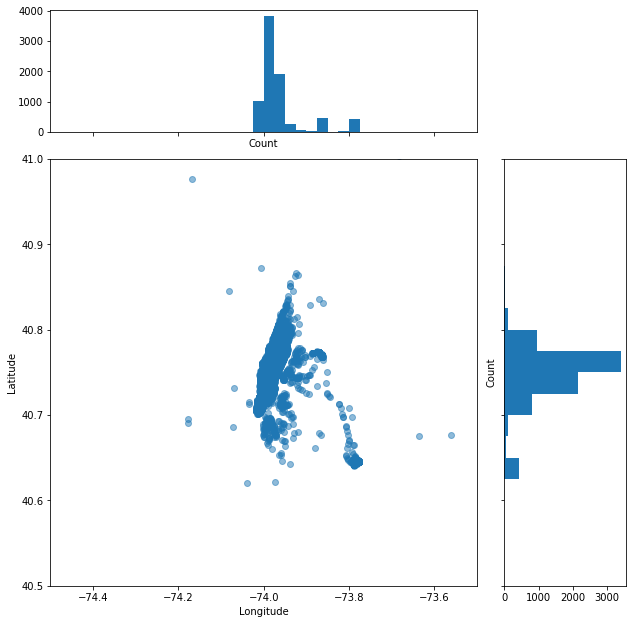

store_and_fwd_flag_Y_dropoff


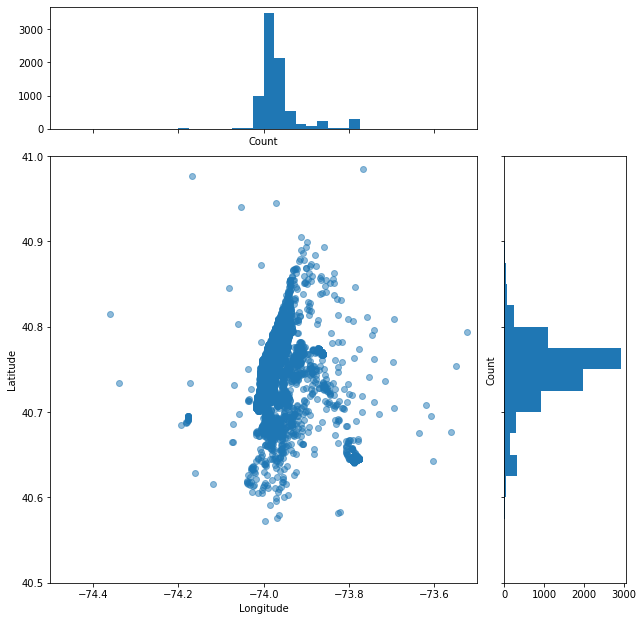

store_and_fwd_flag_N_pickup


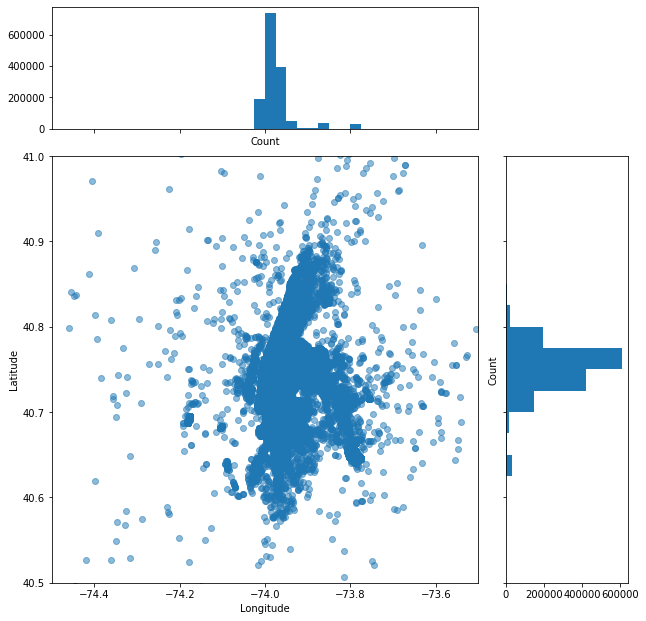

store_and_fwd_flag_N_dropoff


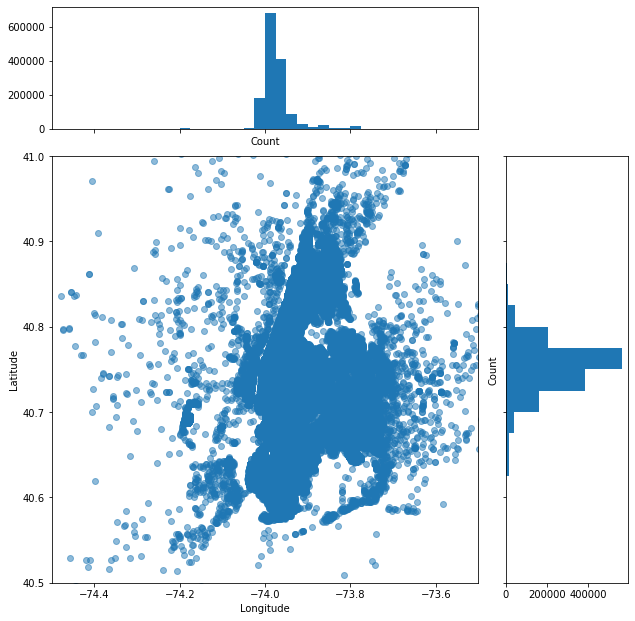

vendor_id_1_pickup


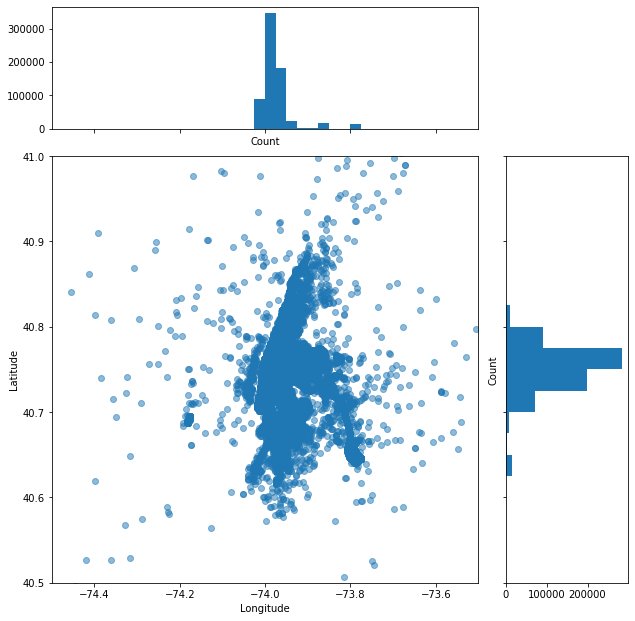

vendor_id_1_dropoff


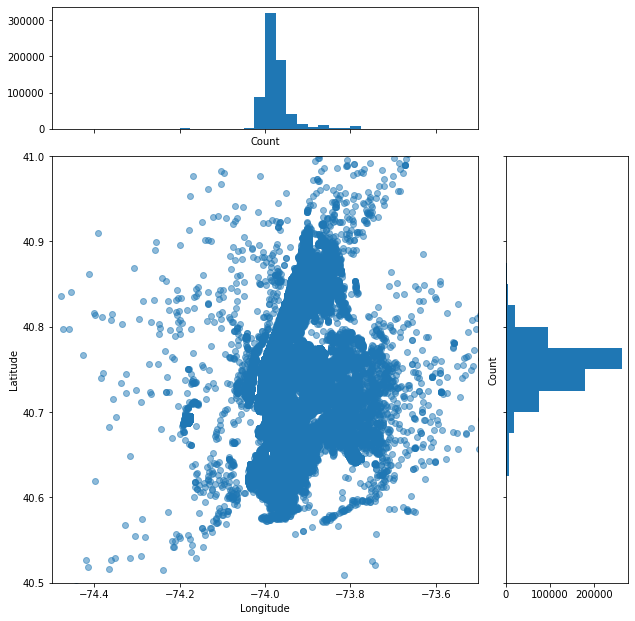

vendor_id_2_pickup


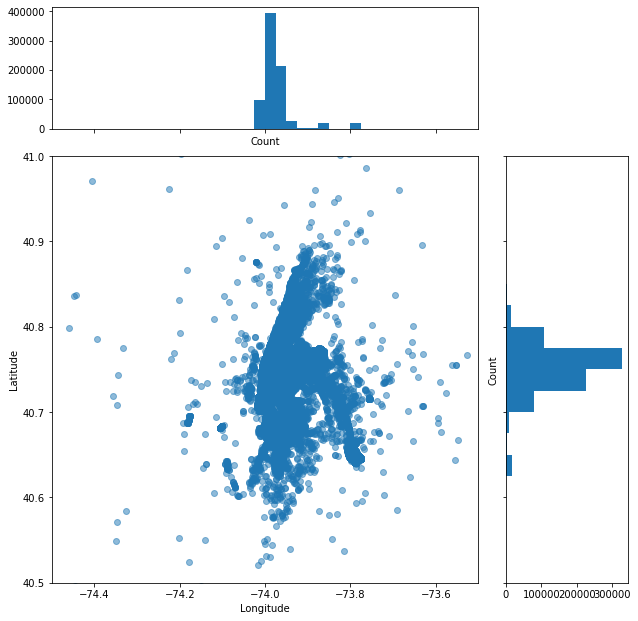

vendor_id_2_dropoff


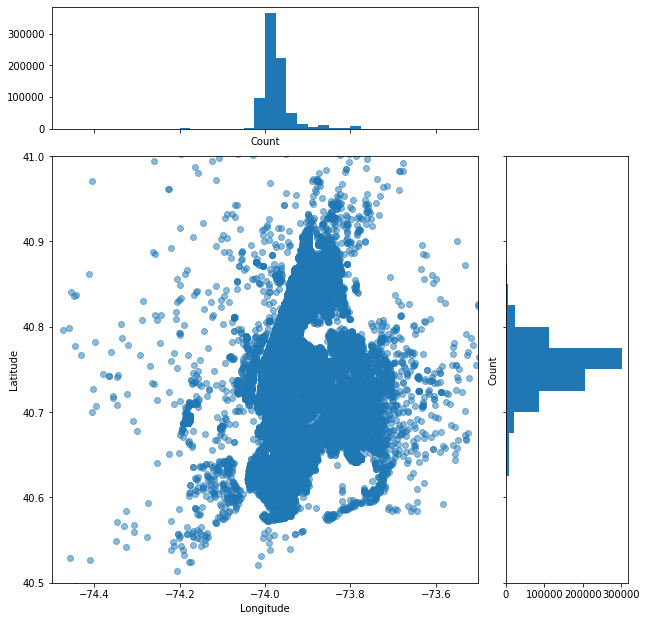

CPU times: user 5min 57s, sys: 4.62 s, total: 6min 1s
Wall time: 5min 58s


In [9]:
%%time

# Set larger font size
matplotlib.rcParams["font.size"] = 16

# Function to plot scatter plot with histograms
def scatter_hist(x, y, ax, ax_histx, ax_histy, xlim_vals, ylim_vals):
    # Remove labels for clarity
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # Scatter plot with transparency
    ax.scatter(x, y, alpha=0.5)

    # Set the x and y limits using the pre-defined values
    ax.set_xlim(xlim_vals)
    ax.set_ylim(ylim_vals)

    # Set the title and axis labels for the scatter plot
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Define the limits based on the max values of x and y
    binwidth = 0.025  # Smaller binwidth for finer granularity
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax / binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation="horizontal")

    # Set the axis labels for the marginal histograms
    ax_histx.set_xlabel("Count")
    ax_histy.set_ylabel("Count")

# Pre-defined x and y limits for the main plot
xlim_vals = (-74.5, -73.5)  # Adjust based on your data's longitude range
ylim_vals = (40.5, 41.0)   # Adjust based on your data's latitude range

# Visualize distributions among categorical column `store_and_fwd_flag` & `vendor_id`
# Define the conditions to loop over using a dictionary
conditions = {
    "store_and_fwd_flag": ["Y", "N"],
    "vendor_id": [1, 2]
}

coords = [["pickup_longitude", "pickup_latitude"],
          ["dropoff_longitude", "dropoff_latitude"]]

# Loop through the dict to apply each condition
for col in conditions.keys():
    for cond in conditions[col]:
        # Filter the data based on the current condition
        df_filtered = data[data[col] == cond]

        for coord_pair in coords:
            # Define x and y based on the coordinates
            x = df_filtered[coord_pair[0]]
            y = df_filtered[coord_pair[1]]

            # Create a dynamic title using f-string
            title = f"{col}_{cond}_{coord_pair[0].split('_')[0]}"
            print(title)

            # Set up the figure
            fig = plt.figure(figsize=(10, 10))

            # Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
            # the size of the marginal axes and the main axes in both directions.
            # Also adjust the subplot parameters for a square plot.
            gs = fig.add_gridspec(2, 2, width_ratios=[7, 2], height_ratios=[2, 7],
                                  left=0.1, right=0.9, bottom=0.1, top=0.9,
                                  wspace=0.1, hspace=0.1)

            # Main scatter plot
            ax = fig.add_subplot(gs[1, 0])

            # Marginal histograms
            ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
            ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

            # Call the scatter_hist function with xlim and ylim values
            scatter_hist(x, y, ax, ax_histx, ax_histy, xlim_vals, ylim_vals)

            # Save the plot as an image with the dynamic title
            plt.savefig(os.path.join("images", f"scatter_hist_{title}.png"), dpi=300, bbox_inches="tight")

            # Show the plot
            plt.show()
        
# Reset font size
matplotlib.rcParams["font.size"] = 12

Trips marked with `store_and_fwd_flag = Y` are less frequent, as this flag indicates that these trips are typically backups when trip information cannot be uploaded directly due to service unavailability. When comparing the spatial distributions across different vendors, the patterns are quite similar, with both vendors exhibiting comparable distributions in terms of trip locations.

In [10]:
%%time

# Calculate intermediate variables
data["trip_duration [min]"] = data["trip_duration"] / 60.0
data["log_duration"] = np.log1p(data["trip_duration [min]"])

CPU times: user 15.1 ms, sys: 12 ms, total: 27.1 ms
Wall time: 24 ms


Boxplot for log_duration vs passenger_count:


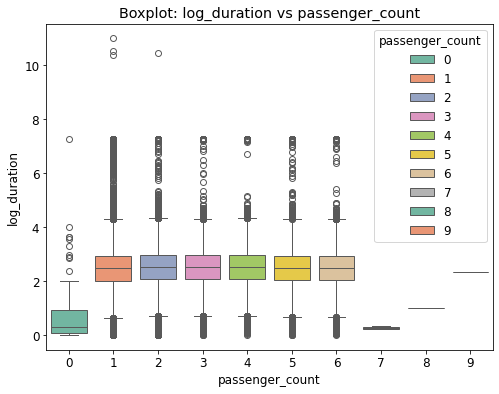

KDE for log_duration vs passenger_count:


<timed exec>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


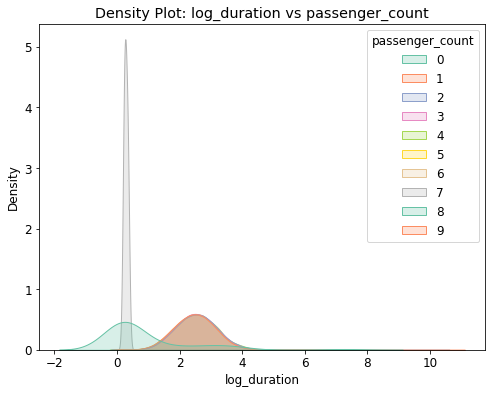

Boxplot for log_duration vs vendor_id:


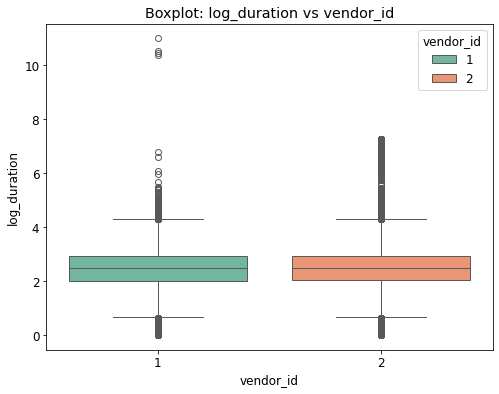

KDE for log_duration vs vendor_id:


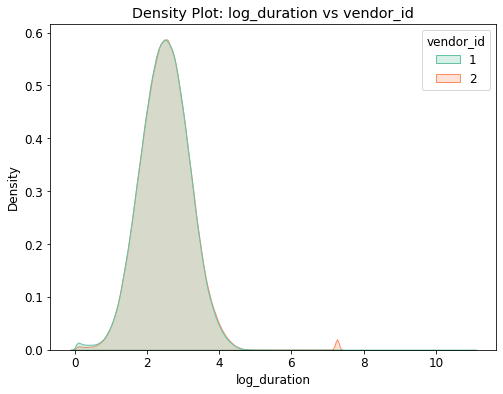

Boxplot for log_duration vs store_and_fwd_flag:


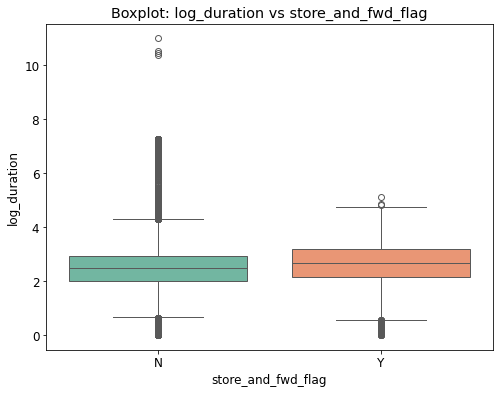

KDE for log_duration vs store_and_fwd_flag:


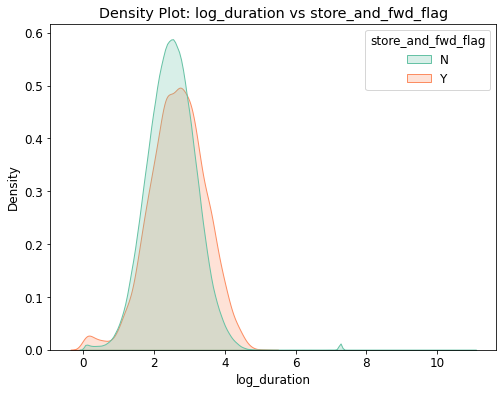

CPU times: user 28.6 s, sys: 6.16 s, total: 34.8 s
Wall time: 24.4 s


In [11]:
%%time

y_columns = ["log_duration"]
x_columns = ["passenger_count", "vendor_id", "store_and_fwd_flag"]

# Iterate over y_columns and x_columns to create boxplots and KDE plots
for y_col in y_columns:
    for x_col in x_columns:
        # Boxplot for y vs x
        print(f"Boxplot for {y_col} vs {x_col}:")
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=x_col, y=y_col, data=data, hue=x_col, palette="Set2")
        plt.title(f"Boxplot: {y_col} vs {x_col}")
        plt.savefig(os.path.join("images", f"boxplot_{y_col.replace(' ', '_').replace('[min]', 'min')}_vs_{x_col}.png"), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Density plot (KDE) for y vs x
        print(f"KDE for {y_col} vs {x_col}:")
        plt.figure(figsize=(8, 6))
        sns.kdeplot(data=data, x=y_col, hue=x_col, fill=True, common_norm=False, palette="Set2")
        plt.title(f"Density Plot: {y_col} vs {x_col}")
        plt.savefig(os.path.join("images", f"density_plot_{y_col.replace(' ', '_').replace('[min]', 'min')}_vs_{x_col}.png"), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

The distributions of logged trip duration are similar across different categories, and most trips involve a small number of passengers (e.g., 1–2). Several trips with zero passengers indicate very brief durations (less than 30 seconds), suggesting possible outliers due to measurement or systematic errors. Despite the overall similarity in patterns across vendors and storage modes, trips from Vendor 2 and trips that were not stored and forwarded exhibit more noticeable extreme values, which is to be further explored in sections below.

In [12]:
%%time

# Initialize the map
nyc_map = folium.Map(location=[40, -95], zoom_start=4)

# Add pickup and dropoff locations as separate marker clusters
pickup_cluster = MarkerCluster(name="Pickups").add_to(nyc_map)
dropoff_cluster = MarkerCluster(name="Dropoffs").add_to(nyc_map)

# Compute percentiles for pickup and dropoff latitude/longitude
pickup_lat_0_3 = np.percentile(data["pickup_latitude"], 0.3)
pickup_lat_99_7 = np.percentile(data["pickup_latitude"], 99.7)
pickup_lon_0_3 = np.percentile(data["pickup_longitude"], 0.3)
pickup_lon_99_7 = np.percentile(data["pickup_longitude"], 99.7)

dropoff_lat_0_3 = np.percentile(data["dropoff_latitude"], 0.3)
dropoff_lat_99_7 = np.percentile(data["dropoff_latitude"], 99.7)
dropoff_lon_0_3 = np.percentile(data["dropoff_longitude"], 0.3)
dropoff_lon_99_7 = np.percentile(data["dropoff_longitude"], 99.7)

# Filter points at the 0.3% and 99.7% percentiles
pickup_extreme = data[(data["pickup_latitude"] <= pickup_lat_0_3) | (data["pickup_latitude"] >= pickup_lat_99_7) |
                      (data["pickup_longitude"] <= pickup_lon_0_3) | (data["pickup_longitude"] >= pickup_lon_99_7)]

dropoff_extreme = data[(data["dropoff_latitude"] <= dropoff_lat_0_3) | (data["dropoff_latitude"] >= dropoff_lat_99_7) |
                        (data["dropoff_longitude"] <= dropoff_lon_0_3) | (data["dropoff_longitude"] >= dropoff_lon_99_7)]

# Apply frac=0.1 sampling for the rest of the data
pickup_sample = data[~data.index.isin(pickup_extreme.index)].groupby(["pickup_latitude", "pickup_longitude"]).sample(frac=0.1, random_state=42)
dropoff_sample = data[~data.index.isin(dropoff_extreme.index)].groupby(["dropoff_latitude", "dropoff_longitude"]).sample(frac=0.1, random_state=42)

# Add extreme pickup points
for _, row in pickup_extreme.iterrows():
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=5,
        color="mediumorchid",  # Highlight extreme points in red
        fill=True,
        fill_color="mediumorchid",
        fill_opacity=0.6,
    ).add_to(pickup_cluster)

# Add extreme dropoff points
for _, row in dropoff_extreme.iterrows():
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=5,
        color="cornflowerblue",  # Highlight extreme points in dark red
        fill=True,
        fill_color="cornflowerblue",
        fill_opacity=0.6,
    ).add_to(dropoff_cluster)

# Add unique pickup points (from the sample)
for _, row in pickup_sample.iterrows():
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=5,
        color="mediumorchid",
        fill=True,
        fill_color="mediumorchid",
        fill_opacity=0.6,
    ).add_to(pickup_cluster)

# Add unique dropoff points (from the sample)
for _, row in dropoff_sample.iterrows():
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=5,
        color="cornflowerblue",
        fill=True,
        fill_color="cornflowerblue",
        fill_opacity=0.6,
    ).add_to(dropoff_cluster)

# Add layer control to toggle visibility
folium.LayerControl().add_to(nyc_map)

# Save the map as an HTML file
nyc_map.save(os.path.join("images","nyc_taxi_map.html"))

CPU times: user 3min 29s, sys: 7.99 s, total: 3min 37s
Wall time: 3min 36s


The generated map is saved in HTML format to optimize memory usage and maintain code safety. Instead of directly referencing the map, it is displayed through screenshots. To forcefully load the map, set `trust_enabled = True` and `File -> Trust Notebook`.

In [13]:
%%time

trust_enabled = False

# Show the map iff the notebook is trusted
if trust_enabled:
    nyc_map

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 13.1 µs


![Map of Trip Locations in USA](images/map_usa.png)

![Map of Trip Locations in New York](images/map_newyork.png)

In the generated figure of representative trip locations, it is evident that the majority of the data points are concentrated in New York City, with Manhattan holding the largest share. Surrounding areas such as Hempstead, Elizabeth, and New Brunswick have relatively few records. Additionally, extreme outliers can be observed in the Atlantic Ocean, as well as in the state of California, Canada and even in the Atlantic Sea, and should be dropped out during further analysis.

In [14]:
%%time

# Define WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Compute great-circle distance in kilometers
data["geodesic_distance"] = data.apply(
    lambda row: geod.inv(row["pickup_longitude"], row["pickup_latitude"],
                         row["dropoff_longitude"], row["dropoff_latitude"])[2] / 1000, axis=1
)

CPU times: user 20.7 s, sys: 660 ms, total: 21.4 s
Wall time: 21.3 s


In [15]:
%%time

# Calculate value occurrences of longtitudes & latitudes
all_lat = np.array(list(data["pickup_latitude"]) + list(data["dropoff_latitude"]))
all_long = np.array(list(data["pickup_longitude"]) + list(data["dropoff_longitude"]))
all_distance = np.array(data["geodesic_distance"])

# Calculate the percentile limits for latitude, longitude, and trip duration
long_limits = [np.percentile(all_long, 0.15), np.percentile(all_long, 99.85)]
lat_limits = [np.percentile(all_lat, 0.15), np.percentile(all_lat, 99.85)]
dur_limits = [300, 72000]
dist_limits = [0.1, 720]

print("Longitude Limits:", long_limits)
print("Latitude Limits:", lat_limits)
print("Duration Limits:", dur_limits)
print("Distance Limits:", dist_limits)

Longitude Limits: [-74.0427022514343, -73.77650451660156]
Latitude Limits: [40.627817735672, 40.86748912620544]
Duration Limits: [300, 72000]
Distance Limits: [0.1, 720]
CPU times: user 865 ms, sys: 92.1 ms, total: 957 ms
Wall time: 953 ms


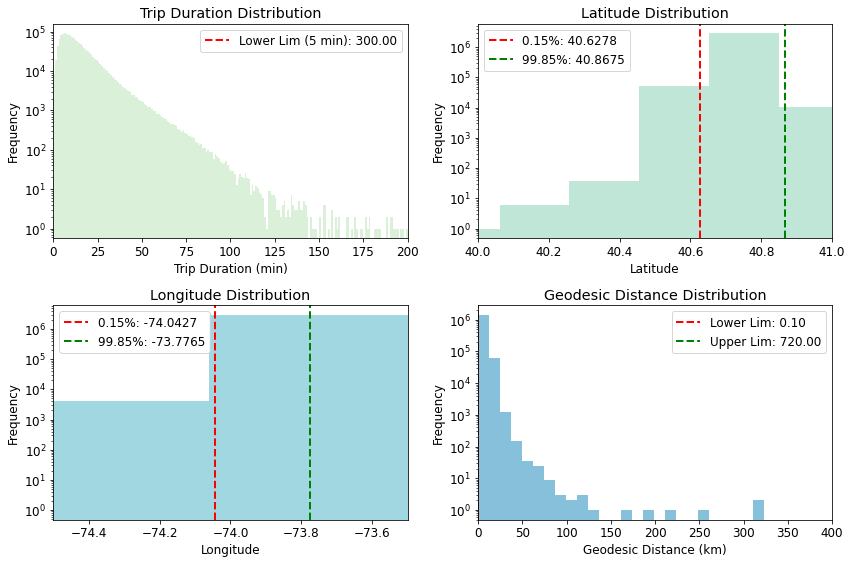

CPU times: user 8.38 s, sys: 645 ms, total: 9.03 s
Wall time: 7.78 s


In [16]:
%%time

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 row, 2 columns

# Plot trip duration histogram
trip_min = int(data["trip_duration [min]"].min() / 60)
trip_max = int(data["trip_duration [min]"].max() / 60)

axes[0, 0].hist(data["trip_duration [min]"], bins=np.arange(trip_min, trip_max + 1, 1), color=colors_b[1], alpha=0.6)
axes[0, 0].axvline(dur_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"Lower Lim (5 min): {dur_limits[0]:.2f}")
# axes[0, 0].axvline(dur_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"Upper Lim (20h): {dur_limits[1]:.2f}")
# axes[0, 0].axvline(5, color="yellow", linestyle="dashed", linewidth=2, label=f"5 min trip")
axes[0, 0].set_title("Trip Duration Distribution")
axes[0, 0].set_xlim([0, 200])
axes[0, 0].set_xlabel("Trip Duration (min)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_yscale("log")
axes[0, 0].legend()

# Plot latitude histogram
axes[0, 1].hist(all_lat, bins=100, color=colors_b[2], alpha=0.6)
axes[0, 1].axvline(lat_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"0.15%: {lat_limits[0]:.4f}")
axes[0, 1].axvline(lat_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"99.85%: {lat_limits[1]:.4f}")
axes[0, 1].set_title("Latitude Distribution")
axes[0, 1].set_xlim([40, 41])
axes[0, 1].set_xlabel("Latitude")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_yscale("log")
axes[0, 1].legend()

# Plot longitude histogram
axes[1, 0].hist(all_long, bins=100, color=colors_b[3], alpha=0.6)
axes[1, 0].axvline(long_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"0.15%: {long_limits[0]:.4f}")
axes[1, 0].axvline(long_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"99.85%: {long_limits[1]:.4f}")
axes[1, 0].set_title("Longitude Distribution")
axes[1, 0].set_xlim([-74.5, -73.5])
axes[1, 0].set_xlabel("Longitude")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_yscale("log")
axes[1, 0].legend()

# Plot Geodesic Distance histogram
axes[1, 1].hist(all_distance, bins=100, color=colors_b[4], alpha=0.6)
axes[1, 1].axvline(dist_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"Lower Lim: {dist_limits[0]:.2f}")
axes[1, 1].axvline(dist_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"Upper Lim: {dist_limits[1]:.2f}")
axes[1, 1].set_title("Geodesic Distance Distribution")
axes[1, 1].set_xlim([0, 400])
axes[1, 1].set_xlabel("Geodesic Distance (km)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_yscale("log")
axes[1, 1].legend()

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("images/raw_trip_data_log_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

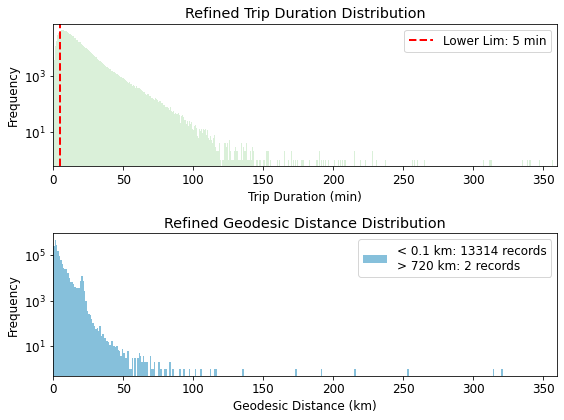

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Plot trip duration histogram with more bins
trip_min = int(data["trip_duration [min]"].min() / 60)
trip_max = int(data["trip_duration [min]"].max() / 60)

axes[0].hist(data["trip_duration [min]"], bins=np.arange(trip_min, trip_max + 1, 0.5), color=colors_b[1], alpha=0.6)
axes[0].axvline(5, color="red", linestyle="dashed", linewidth=2, label=f"Lower Lim: 5 min")
axes[0].set_title("Refined Trip Duration Distribution")
axes[0].set_xlim([0, 360]) # 6-h length for outliers
axes[0].set_xlabel("Trip Duration (min)")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale("log")
axes[0].legend()

# Count records for geodesic distances
count_below_0_1 = (data["geodesic_distance"] < 0.1).sum()
count_above_720 = (data["geodesic_distance"] > 720).sum()

# Plot Geodesic Distance histogram with more bins
axes[1].hist(data["geodesic_distance"], bins=np.arange(0, 360 + 1), color=colors_b[4], alpha=0.6)
axes[1].set_title("Refined Geodesic Distance Distribution")
axes[1].set_xlim([0, 360])
axes[1].set_xlabel("Geodesic Distance (km)")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")

# Add legend with counts in the upper right corner
axes[1].legend([f"< 0.1 km: {count_below_0_1} records\n> 720 km: {count_above_720} records"], loc="upper right")

# Adjust layout and save plot with new title
plt.tight_layout()
plt.savefig("images/refined_trip_data_log_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

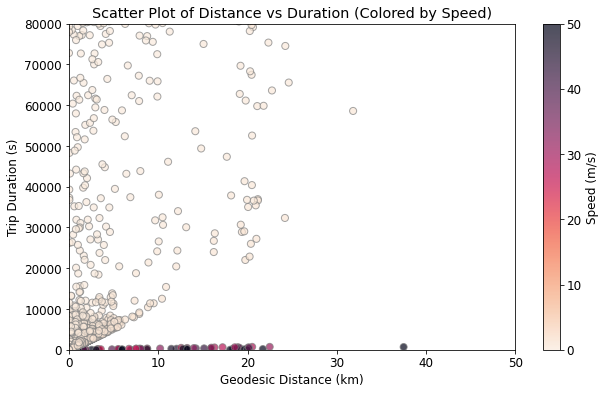

CPU times: user 780 ms, sys: 120 ms, total: 900 ms
Wall time: 717 ms


<Figure size 432x288 with 0 Axes>

In [18]:
%%time

# Calculate speed in m/s
data["speed"] = (data["geodesic_distance"] / data["trip_duration"]) * 1000

# Identify trips that fall outside the speed limits
outlier_speed = data[(data["speed"] < 1) | (data["speed"] > 25)]

# Clipping speed values to be within 0-100 for colormap
norm_speed = np.clip(outlier_speed["speed"], 0, 50)

# Scatter plot of distance vs. duration, colored by speed
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    outlier_speed["geodesic_distance"],
    outlier_speed["trip_duration"],
    c=norm_speed,
    cmap="rocket_r",
    alpha=0.7,
    edgecolors="grey",
    s=50
)

cbar = plt.colorbar(sc)
cbar.set_label("Speed (m/s)")
cbar.set_ticks([0, 10, 20, 30, 40, 50])

plt.xlabel("Geodesic Distance (km)")
plt.ylabel("Trip Duration (s)")
plt.title("Scatter Plot of Distance vs Duration (Colored by Speed)")

plt.xlim(0, 50)
plt.ylim(0, 80000)
plt.show()
plt.savefig("images/scatter-plot-of-distance-colored.png", dpi=300, bbox_inches="tight")

The plot highlights two key outliers to remove:
- Trip Duration Outliers: Extremely long durations resulting in speeds below 1 m/s, much slower than walking pace. These are likely due to errors, such as a driver leaving the trip record running while resting.
- Speed Outliers: Trips under 10~20 km showing speeds above 50 m/s (180 km/h), which are unrealistic for a taxi. These are likely due data recording issues.
Removing these outliers ensures the dataset is more accurate and reliable for further analysis.

## Remove Extreme Outliers

In [19]:
%%time

# Store the original number of records
original_count = len(data)

# Keep duration and dist a looser limit for further plotting
dur_limits = [np.percentile(data["trip_duration [min]"], 0.15), np.percentile(data["trip_duration [min]"], 99.85)]
dist_limits = [np.percentile(all_distance, 0.15), np.percentile(all_distance, 99.85)]

# Remove rows where latitude, longitude, trip duration or trip distance fall outside the limits
data = data[(data["pickup_latitude"] >= lat_limits[0]) & (data["pickup_latitude"] <= lat_limits[1])]
data = data[(data["dropoff_latitude"] >= lat_limits[0]) & (data["dropoff_latitude"] <= lat_limits[1])]
data = data[(data["pickup_longitude"] >= long_limits[0]) & (data["pickup_longitude"] <= long_limits[1])]
data = data[(data["dropoff_longitude"] >= long_limits[0]) & (data["dropoff_longitude"] <= long_limits[1])]
data = data[(data["trip_duration [min]"] >= dur_limits[0]) & (data["trip_duration [min]"] <= dur_limits[1])]
data = data[(data["geodesic_distance"] >= dist_limits[0]) & (data["geodesic_distance"] <= dist_limits[1])]

# Reset the index after filtering
data = data.reset_index(drop=True)

# Calculate the number of dropped records
dropped_count = original_count - len(data)
print(f"Total records dropped: {dropped_count}")

Total records dropped: 20347
CPU times: user 818 ms, sys: 176 ms, total: 994 ms
Wall time: 992 ms


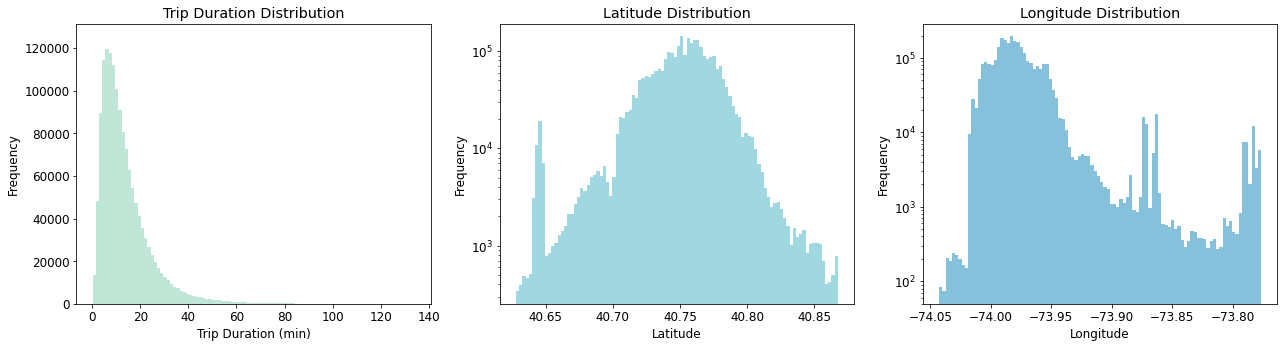

CPU times: user 3.23 s, sys: 453 ms, total: 3.68 s
Wall time: 3.07 s


In [20]:
%%time

# Recalculate value occurrences of longtitudes & latitudes
all_lat = np.array(list(data["pickup_latitude"]) + list(data["dropoff_latitude"]))
all_long = np.array(list(data["pickup_longitude"]) + list(data["dropoff_longitude"]))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot trip duration histogram
n, bins, patches = axes[0].hist(data["trip_duration [min]"], bins=100, color=colors_b[2], alpha=0.6)
axes[0].set_title("Trip Duration Distribution")
axes[0].set_xlabel("Trip Duration (min)")
axes[0].set_ylabel("Frequency")
axes[0].set_ylim(0, max(n) * 1.1)  # Set y-axis range (10% extra for padding)

# Plot latitude histogram
n, bins, patches = axes[1].hist(all_lat, bins=100, color=colors_b[3], alpha=0.6)
axes[1].set_title("Latitude Distribution")
axes[1].set_xlabel("Latitude")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")

# Plot longitude histogram
n, bins, patches = axes[2].hist(all_long, bins=100, color=colors_b[4], alpha=0.6)
axes[2].set_title("Longitude Distribution")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Frequency")
axes[2].set_yscale("log")

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("images/removed_trip_data_log_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Skimming Dataset with Visualizations: Spatial Patterns

### Lower & Upper Limits of Longitude & Latitude

In [21]:
%%time

# Combine pickup and dropoff coordinates for longitude and latitude
combined_longitude = np.concatenate([data["pickup_longitude"].values, data["dropoff_longitude"].values])
combined_latitude = np.concatenate([data["pickup_latitude"].values, data["dropoff_latitude"].values])

# Find the min and max values for longitude and latitude
min_longitude = combined_longitude.min()
max_longitude = combined_longitude.max()

min_latitude = combined_latitude.min()
max_latitude = combined_latitude.max()

# Print the results
print("Longitude: Min = {}, Max = {}".format(min_longitude, max_longitude))
print("Latitude: Min = {}, Max = {}".format(min_latitude, max_latitude))

Longitude: Min = -74.04267883300781, Max = -73.77650451660156
Latitude: Min = 40.6278190612793, Max = 40.867488861083984
CPU times: user 19.1 ms, sys: 116 µs, total: 19.3 ms
Wall time: 17.4 ms


### Trip Duration vs. Geodesic Distance between Pickup & Dropoff

In [22]:
%%time

# Define WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Compute great-circle distance in kilometers
data["geodesic_distance"] = data.apply(
    lambda row: geod.inv(row["pickup_longitude"], row["pickup_latitude"],
                         row["dropoff_longitude"], row["dropoff_latitude"])[2] / 1000, axis=1
)

CPU times: user 20.5 s, sys: 625 ms, total: 21.1 s
Wall time: 21 s


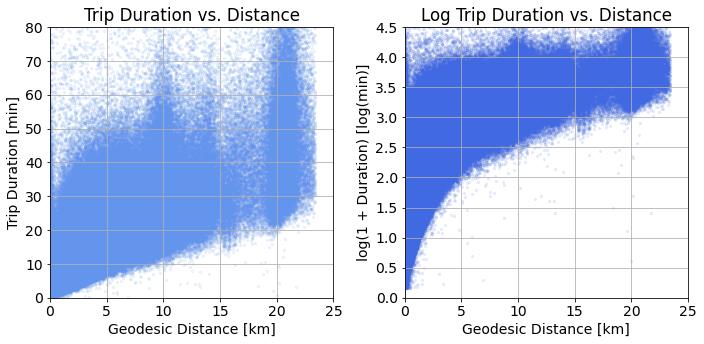

CPU times: user 16.1 s, sys: 324 ms, total: 16.4 s
Wall time: 15.9 s


In [26]:
%%time

# Set global font size for all plot elements
plt.rcParams.update({'font.size': 14})  # Update all font sizes to 14

# Create subplots
fig, axArray = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot of duration vs. aerial distance
sc1 = axArray[0].scatter(data["geodesic_distance"], data["trip_duration [min]"], 
                         c="cornflowerblue", s=5, alpha=0.1)
axArray[0].set_xlabel("Geodesic Distance [km]")
axArray[0].set_ylabel("Trip Duration [min]")
axArray[0].set_xlim(0, 25)
axArray[0].set_ylim(0, 80)
axArray[0].set_title("Trip Duration vs. Distance")
axArray[0].grid(True)

# Scatter plot of log duration vs. aerial distance
sc2 = axArray[1].scatter(data["geodesic_distance"], data["log_duration"], 
                         c="royalblue", s=5, alpha=0.1)
axArray[1].set_xlabel("Geodesic Distance [km]")
axArray[1].set_ylabel("log(1 + Duration) [log(min)]")
axArray[1].set_xlim(0, 25)
axArray[1].set_ylim(0, 4.5)
axArray[1].set_title("Log Trip Duration vs. Distance")
axArray[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"images/trip_duration_vs_euclidan_distance.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

# Reset global font size for all plot elements
plt.rcParams.update({'font.size': 12})  # Update all font sizes to 12

### Pick-up & Drop-off Location Density

Pickups dropped: 192, Dropoffs dropped: 1275


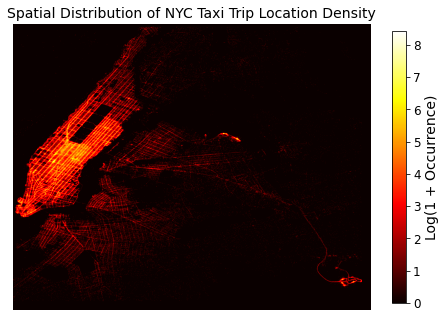

CPU times: user 2.86 s, sys: 220 ms, total: 3.08 s
Wall time: 2.72 s


In [32]:
%%time

# Define valid geographic bounds for New York
lat_min, lat_max = 40.62, 40.87         # 0.25
lon_min, lon_max = -74.02, -73.77       # 0.25

# Filter data within the specified range
valid_pickup = (data["pickup_latitude"].between(lat_min, lat_max)) & (data["pickup_longitude"].between(lon_min, lon_max))
valid_dropoff = (data["dropoff_latitude"].between(lat_min, lat_max)) & (data["dropoff_longitude"].between(lon_min, lon_max))

# Count dropped data points
dropped_pickups = len(data) - valid_pickup.sum()
dropped_dropoffs = len(data) - valid_dropoff.sum()
print(f"Pickups dropped: {dropped_pickups}, Dropoffs dropped: {dropped_dropoffs}")

# Keep only valid data
pickup_lons = data.loc[valid_pickup, "pickup_longitude"]
pickup_lats = data.loc[valid_pickup, "pickup_latitude"]
dropoff_lons = data.loc[valid_dropoff, "dropoff_longitude"]
dropoff_lats = data.loc[valid_dropoff, "dropoff_latitude"]

# Define image size
img_sz = (800, 1000)

# Normalize coordinates to fit image dimensions directly in WGS84
pickup_x_inds = ((img_sz[1] * (pickup_lons - lon_min) / (lon_max - lon_min))).astype(int)
pickup_y_inds = (img_sz[0] - (img_sz[0] * (pickup_lats - lat_min) / (lat_max - lat_min))).astype(int)

dropoff_x_inds = ((img_sz[1] * (dropoff_lons - lon_min) / (lon_max - lon_min))).astype(int)
dropoff_y_inds = (img_sz[0] - (img_sz[0] * (dropoff_lats - lat_min) / (lat_max - lat_min))).astype(int)

# Initialize density image
location_density_image = np.zeros(img_sz)

# Update the density map with valid pickup and dropoff locations
for x, y in zip(pickup_x_inds, pickup_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image[y, x] += 1

for x, y in zip(dropoff_x_inds, dropoff_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image[y, x] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(np.log(location_density_image + 1), cmap="hot")  # Apply log transform for better visibility
ax.set_axis_off()

# Add a title
ax.set_title("Spatial Distribution of NYC Taxi Trip Location Density", fontsize=14)

# Add a colorbar with label indicating the density
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("Log(1 + Occurrence)", fontsize=14)

# Save the plot to a PNG file in the "images" directory
plt.savefig("images/heatmap_density.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

The figure highlights the popularity of pickup and drop-off locations, with lighter patterns indicating areas of high occurrence. In New York, the Manhattan region and two major airports (John F. Kennedy International Airport (JFK) and LaGuardia Airport (LGA)) are particularly notable for their high levels of activity. Within Manhattan, the absence of taxis around Central Park is also evident, as the area is marked in black due to restrictions on taxi access. Additionally, lakes, rivers, and green spaces are also represented in black on the figure, signifying that these areas are not utilized for taxi services.

Pickups dropped: 62960, Dropoffs dropped: 84700


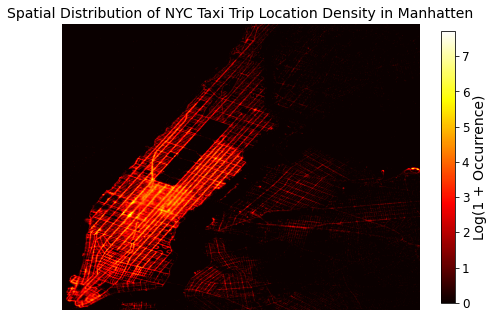

CPU times: user 2.96 s, sys: 308 ms, total: 3.27 s
Wall time: 2.91 s


In [34]:
%%time

# Define valid geographic bounds for Manhattan
lat_min_, lat_max_ = 40.70, 40.85       # 0.15
lon_min_, lon_max_ = -74.02, -73.87     # 0.15

# Filter data within the specified range
valid_pickup = (data["pickup_latitude"].between(lat_min_, lat_max_)) & (data["pickup_longitude"].between(lon_min_, lon_max_))
valid_dropoff = (data["dropoff_latitude"].between(lat_min_, lat_max_)) & (data["dropoff_longitude"].between(lon_min_, lon_max_))

# Count dropped data points
dropped_pickups = len(data) - valid_pickup.sum()
dropped_dropoffs = len(data) - valid_dropoff.sum()
print(f"Pickups dropped: {dropped_pickups}, Dropoffs dropped: {dropped_dropoffs}")

# Keep only valid data
pickup_lons = data.loc[valid_pickup, "pickup_longitude"]
pickup_lats = data.loc[valid_pickup, "pickup_latitude"]
dropoff_lons = data.loc[valid_dropoff, "dropoff_longitude"]
dropoff_lats = data.loc[valid_dropoff, "dropoff_latitude"]

# Normalize coordinates to fit image dimensions directly in WGS84
pickup_x_inds = ((img_sz[1] * (pickup_lons - lon_min_) / (lon_max_ - lon_min_))).astype(int)
pickup_y_inds = (img_sz[0] - (img_sz[0] * (pickup_lats - lat_min_) / (lat_max_ - lat_min_))).astype(int)

dropoff_x_inds = ((img_sz[1] * (dropoff_lons - lon_min_) / (lon_max_ - lon_min_))).astype(int)
dropoff_y_inds = (img_sz[0] - (img_sz[0] * (dropoff_lats - lat_min_) / (lat_max_ - lat_min_))).astype(int)

# Initialize density image
location_density_image_ = np.zeros(img_sz)

# Update the density map with valid pickup and dropoff locations
for x, y in zip(pickup_x_inds, pickup_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image_[y, x] += 1

for x, y in zip(dropoff_x_inds, dropoff_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image_[y, x] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(np.log(location_density_image_ + 1), cmap="hot")  # Apply log transform for better visibility
ax.set_axis_off()

# Add a title
ax.set_title("Spatial Distribution of NYC Taxi Trip Location Density in Manhatten", fontsize=14)

# Add a colorbar with label indicating the density
cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cbar.set_label("Log(1 + Occurrence)", fontsize=14)

# Save the plot to a PNG file in the "images" directory
plt.savefig("images/heatmap_density_manhattan.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

### Clusters of Stereotypical Template Trips

In [25]:
%%time

# Extract relevant columns from the `data` dataframe
trip_attributes = np.array(data.loc[:, ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "trip_duration [min]"]])

# Calculate the mean and standard deviation for z-score normalization
mean_trip_attr = trip_attributes.mean(axis=0)
std_trip_attr = trip_attributes.std(axis=0)

# Normalize the trip_attributes using z-score
trip_attributes = zscore(trip_attributes, axis=0)

CPU times: user 119 ms, sys: 8.04 ms, total: 127 ms
Wall time: 126 ms


In [26]:
%%time

# Number of clusters
num_clusters = 80

# Apply MiniBatchKMeans clustering
trip_kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, batch_size=120000, n_init=200, random_state=42)
cluster_inds = trip_kmeans_model.fit_predict(trip_attributes)

# Count the frequency of each cluster
cluster_total_counts, _ = np.histogram(cluster_inds, bins=num_clusters)

# Sort clusters by frequency
sorted_cluster_inds = np.flipud(np.argsort(cluster_total_counts))

CPU times: user 16min 40s, sys: 11min 20s, total: 28min 1s
Wall time: 3min 32s


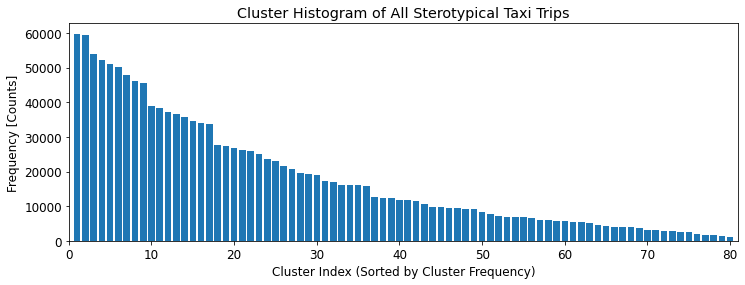

CPU times: user 679 ms, sys: 219 ms, total: 898 ms
Wall time: 537 ms


In [27]:
%%time

# Plot histogram of clusters
plt.figure(figsize=(12, 4))
plt.title("Cluster Histogram of All Sterotypical Taxi Trips")
plt.bar(range(1, num_clusters + 1), cluster_total_counts[sorted_cluster_inds])
plt.ylabel("Frequency [Counts]")
plt.xlabel("Cluster Index (Sorted by Cluster Frequency)")
plt.xlim(0, num_clusters + 1)

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/cluster_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [28]:
%%time

# Function to convert latitude/longitude to image coordinates
def convert_to_image_coords(lat, lon, lat_range, lon_range, image_size):
    lat_inds = image_size[0] - (image_size[0] * (lat - lat_range[0]) / (lat_range[1] - lat_range[0])).astype(int)
    lon_inds = (image_size[1] * (lon - lon_range[0]) / (lon_range[1] - lon_range[0])).astype(int)
    return lat_inds, lon_inds

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 14.5 µs


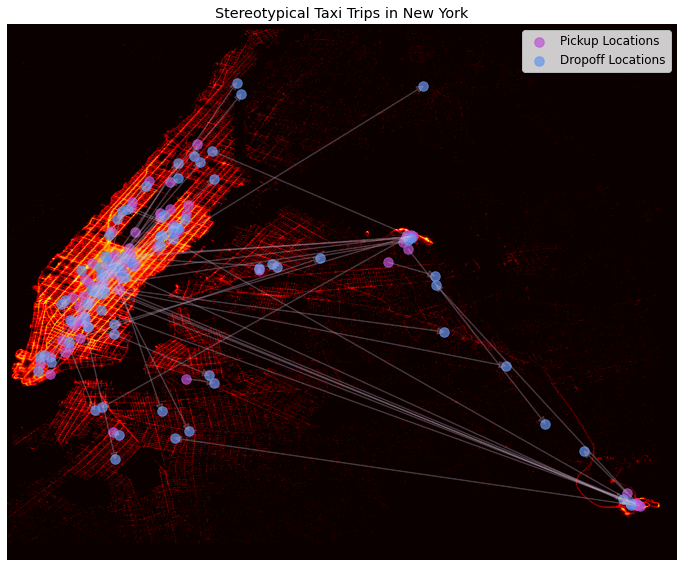

CPU times: user 2.66 s, sys: 671 ms, total: 3.33 s
Wall time: 2.97 s


In [29]:
%%time

# Define valid geographic bounds for Manhattan
lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# Get cluster centers (template trips)
top_clusters = np.argsort(cluster_total_counts)
template_trips = trip_kmeans_model.cluster_centers_ * std_trip_attr + mean_trip_attr

# Extract source and destination coordinates
src_coords = template_trips[top_clusters, :2]  # Pickup latitude, longitude
dst_coords = template_trips[top_clusters, 2:4]  # Dropoff latitude, longitude

# Convert to image coordinates
src_im_coords = convert_to_image_coords(src_coords[:, 0], src_coords[:, 1], lat_range, lon_range, img_sz)
dst_im_coords = convert_to_image_coords(dst_coords[:, 0], dst_coords[:, 1], lat_range, lon_range, img_sz)

# Plot template trips
plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image + 1), cmap="hot")
plt.scatter(src_im_coords[1], src_im_coords[0], c="mediumorchid", s=90, alpha=0.7, label="Pickup Locations")
plt.scatter(dst_im_coords[1], dst_im_coords[0], c="cornflowerblue", s=90, alpha=0.7, label="Dropoff Locations")

# Draw arrows for trips
for i in range(len(src_im_coords[0])):
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="thistle", facecolor="thistle", width=0.8, alpha=0.2,
              head_width=10.0, head_length=10.0, length_includes_head=True)

# Add labels and legend
plt.title("Stereotypical Taxi Trips in New York")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(False)
plt.axis("off")

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/top_common_stereotypical_trips_new_york.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

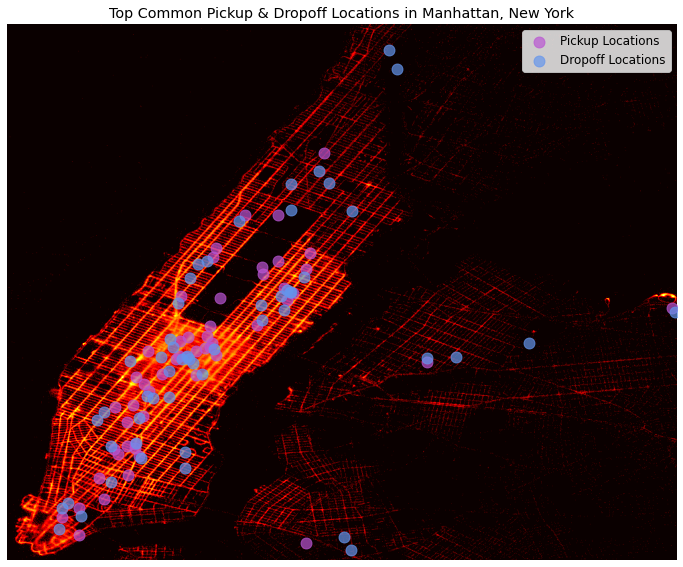

CPU times: user 2.37 s, sys: 358 ms, total: 2.73 s
Wall time: 2.37 s


In [30]:
%%time

# Define valid geographic bounds for Manhattan
lat_range_ = (lat_min_, lat_max_)
lon_range_ = (lon_min_, lon_max_)

# Get cluster centers (template trips)
top_clusters_ = np.argsort(cluster_total_counts)[-64:]  # Get indices of top 50 clusters
template_trips_ = trip_kmeans_model.cluster_centers_ * std_trip_attr + mean_trip_attr

# Extract source and destination coordinates
src_coords = template_trips_[top_clusters_, :2]  # Pickup latitude, longitude
dst_coords = template_trips_[top_clusters_, 2:4]  # Dropoff latitude, longitude

# Filter trips within Manhattan bounds
valid_src_mask = (lat_min_ <= src_coords[:, 0]) & (src_coords[:, 0] <= lat_max_) & \
                 (lon_min_ <= src_coords[:, 1]) & (src_coords[:, 1] <= lon_max_)
valid_dst_mask = (lat_min_ <= dst_coords[:, 0]) & (dst_coords[:, 0] <= lat_max_) & \
                 (lon_min_ <= dst_coords[:, 1]) & (dst_coords[:, 1] <= lon_max_)

# Keep only trips where both pickup and dropoff are within Manhattan
valid_trips_mask = valid_src_mask & valid_dst_mask
filtered_src_coords = src_coords[valid_trips_mask]
filtered_dst_coords = dst_coords[valid_trips_mask]

# Convert to image coordinates
src_im_coords_ = convert_to_image_coords(filtered_src_coords[:, 0], filtered_src_coords[:, 1], lat_range_, lon_range_, img_sz)
dst_im_coords_ = convert_to_image_coords(filtered_dst_coords[:, 0], filtered_dst_coords[:, 1], lat_range_, lon_range_, img_sz)

# Plot template trips
plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image_ + 1), cmap="hot")

# Plot pickup and dropoff locations
plt.scatter(src_im_coords_[1], src_im_coords_[0], c="mediumorchid", s=120, alpha=0.7, label="Pickup Locations")
plt.scatter(dst_im_coords_[1], dst_im_coords_[0], c="cornflowerblue", s=120, alpha=0.7, label="Dropoff Locations")

# Add labels and legend
plt.title("Top Common Pickup & Dropoff Locations in Manhattan, New York")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.axis("off")  # Remove axis

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/top_common_stereotypical_trips_manhattan.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

The data reveals an uneven distribution of pickup and dropoff locations, with the periphery of Manhattan predominantly serving as the dropoff area. Pickups are most commonly observed in Manhattan, airports, and select regions of Brooklyn and Queens. This suggests that cross-borough commuting is common between Manhattan, Brooklyn, and Queens.

## Skimming Dataset with Visualizations: Temporal Patterns

In [31]:
%%time

# Generate detailed date-time fields for pickups
pickup_times = pd.to_datetime(data["pickup_datetime"])

data["pickup_hour_of_day"] = (pickup_times.dt.hour * 60.0 + pickup_times.dt.minute) / 60.0
data["dropoff_hour_of_day"] = data["pickup_hour_of_day"] + data["trip_duration [min]"] / 60.0

data["day_of_week"] = pickup_times.dt.weekday
data["hour_of_week"] = data["day_of_week"] * 24.0 + data["pickup_hour_of_day"]

data["month_of_year"] = pickup_times.dt.month
data["day_of_year"] = pickup_times.dt.dayofyear
data["week_of_year"] = pickup_times.dt.isocalendar().week
data["hour_of_year"] = data["day_of_year"] * 24.0 + data["pickup_hour_of_day"]

CPU times: user 795 ms, sys: 18.6 ms, total: 814 ms
Wall time: 812 ms


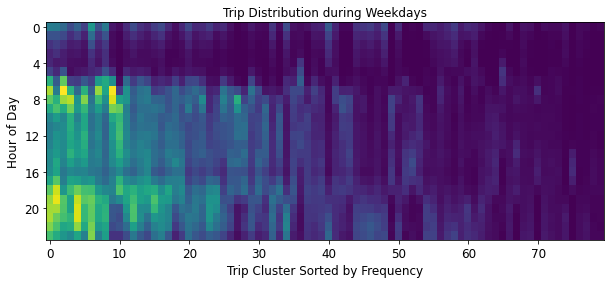

CPU times: user 870 ms, sys: 185 ms, total: 1.05 s
Wall time: 693 ms


In [32]:
%%time

# Calculate trip distribution for different hours of the weekday
hours_of_day = np.sort(data["pickup_hour_of_day"].astype(int).unique())
cluster_distribution_hour_of_day_weekday = np.zeros((len(hours_of_day), num_clusters))

# Calculate trip distribution for each hour of the day on weekdays
for k, hour in enumerate(hours_of_day):
    selected_inds = (data["pickup_hour_of_day"].astype(int) == hour) & (data["day_of_week"] <= 4)  # Weekdays (Mon-Fri)
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_hour_of_day_weekday[k, :] = curr_distribution

# Calculate the frequency of each cluster
cluster_frequencies = np.sum(cluster_distribution_hour_of_day_weekday, axis=0)

# Get sorted indices based on frequency (highest frequency first)
sorted_cluster_indices = np.argsort(cluster_frequencies)[::-1]

# Reorder the cluster distribution matrix based on sorted cluster indices
cluster_distribution_hour_of_day_weekday_sorted = cluster_distribution_hour_of_day_weekday[:, sorted_cluster_indices]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title("Trip Distribution during Weekdays", fontsize=12)
ax.imshow(cluster_distribution_hour_of_day_weekday_sorted, aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_xlabel("Trip Cluster Sorted by Frequency")
ax.set_ylabel("Hour of Day")
ax.set_yticks(np.arange(0, 24, 4))

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/trip_distribution_weekdays_by_hour_sorted.png", dpi=300, bbox_inches="tight")

plt.show()

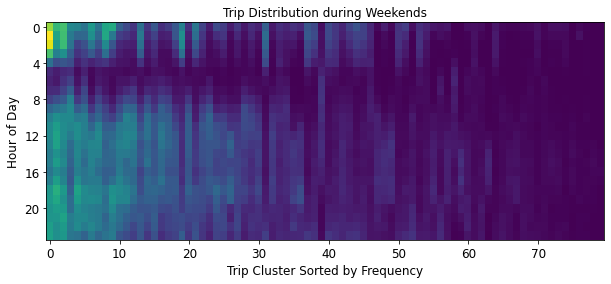

CPU times: user 828 ms, sys: 167 ms, total: 995 ms
Wall time: 639 ms


In [33]:
%%time

# Calculate trip distribution for different hours of the weekends
hours_of_day = np.sort(data["pickup_hour_of_day"].astype(int).unique())
cluster_distribution_hour_of_day_weekday = np.zeros((len(hours_of_day), num_clusters))

# Calculate trip distribution for each hour of the day on weekends
for k, hour in enumerate(hours_of_day):
    selected_inds = (data["pickup_hour_of_day"].astype(int) == hour) & (data["day_of_week"] > 4)  # Weekends (Sat-Sun)
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_hour_of_day_weekday[k, :] = curr_distribution

# Calculate the frequency of each cluster
cluster_frequencies = np.sum(cluster_distribution_hour_of_day_weekday, axis=0)

# Get sorted indices based on frequency (highest frequency first)
sorted_cluster_indices = np.argsort(cluster_frequencies)[::-1]

# Reorder the cluster distribution matrix based on sorted cluster indices
cluster_distribution_hour_of_day_weekday_sorted = cluster_distribution_hour_of_day_weekday[:, sorted_cluster_indices]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title("Trip Distribution during Weekends", fontsize=12)
ax.imshow(cluster_distribution_hour_of_day_weekday_sorted, aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_xlabel("Trip Cluster Sorted by Frequency")
ax.set_ylabel("Hour of Day")
ax.set_yticks(np.arange(0, 24, 4))

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/trip_distribution_weekends_by_hour_sorted.png", dpi=300, bbox_inches="tight")

plt.show()

On weekdays (Monday to Friday), taxi trips are relatively low between 12–5 AM. However, there are noticeable peaks during the morning (6–9 AM) and evening (4–7 PM) rush hours, aligning with typical commuting patterns.

On weekends, daytime trip numbers are generally lower than on weekdays, but there is a significant increase in trips during late-night hours (12–4 AM), likely reflecting nightlife activity.

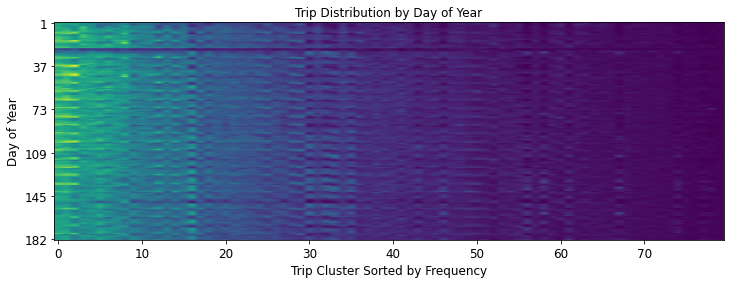

CPU times: user 1.28 s, sys: 168 ms, total: 1.45 s
Wall time: 1.09 s


In [34]:
%%time

# Unique days of the year
days_of_year = np.sort(data["day_of_year"].astype(int).unique())
cluster_distribution_day_of_year = np.zeros((len(days_of_year), num_clusters))

# Compute distribution for each day of the year
for k, day in enumerate(days_of_year):
    selected_inds = data["day_of_year"].astype(int) == day
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_day_of_year[k, :] = curr_distribution

# Compute cluster frequencies
cluster_frequencies = np.sum(cluster_distribution_day_of_year, axis=0)

# Sort clusters by frequency
sorted_cluster_indices = np.argsort(cluster_frequencies)[::-1]

# Reorder distribution matrix based on sorted indices
cluster_distribution_day_of_year_sorted = cluster_distribution_day_of_year[:, sorted_cluster_indices]

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Trip Distribution by Day of Year", fontsize=12)
ax.imshow(cluster_distribution_day_of_year_sorted, aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_xlabel("Trip Cluster Sorted by Frequency")
ax.set_ylabel("Day of Year")
ax.set_yticks(np.linspace(0, len(days_of_year)-1, num=6))
ax.set_yticklabels(np.linspace(1, days_of_year.max(), num=6, dtype=int))  # Approximate tick labels

# Save figure
plt.savefig("images/trip_distribution_by_day_of_year_sorted.png", dpi=300, bbox_inches="tight")

plt.show()

In [35]:
%%time

# Find the top k days with the lowest average trip distribution

# Compute total trip distribution per day
total_trips_per_day = np.sum(cluster_distribution_day_of_year, axis=1)

# Compute average trip distribution per day
average_trips_per_day = total_trips_per_day / num_clusters

# Get indices of the top k least busy days
k = 5  # Change this value as needed
least_busy_indices = np.argsort(average_trips_per_day)[:k]

# Get corresponding days
least_busy_days = days_of_year[least_busy_indices]

print(f"Top {k} least busy days (Day of Year):", least_busy_days)

Top 5 least busy days (Day of Year): [ 23  24 151  25   3]
CPU times: user 302 µs, sys: 113 µs, total: 415 µs
Wall time: 378 µs


This figure clearly shows a periodic pattern, with noticeable drops in taxi trips around Days 23–25 and Days 150–151. In 2016, the record-breaking blizzard in late January (Days 23–25) likely caused the first dip. The second drop, around Days 150–151, coincides with Memorial Day, which falls on the last Monday of May. These factors could explain the observed decline in taxi trips during these periods.

### PCA for Dimensionality Reduction of Sterotypical Trips

In [36]:
%%time

# Get sorted unique hours of the year
hours_of_year = np.sort(data["hour_of_year"].astype(int).unique())

# Initialize matrices
cluster_distribution_hour_of_year = np.zeros((len(range(hours_of_year[0], hours_of_year[-1])), num_clusters))
day_of_year_vec = np.zeros(cluster_distribution_hour_of_year.shape[0])
day_of_week_vec = np.zeros(cluster_distribution_hour_of_year.shape[0])
week_of_year_vec = np.zeros(cluster_distribution_hour_of_year.shape[0])

# Compute distributions
for k, hour in enumerate(hours_of_year):
    selected_inds = data["hour_of_year"].astype(int) == hour
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_hour_of_year[k, :] = curr_distribution[sorted_cluster_indices]
    
    day_of_year_vec[k] = data[selected_inds]["day_of_year"].mean()
    day_of_week_vec[k] = data[selected_inds]["day_of_week"].mean()
    week_of_year_vec[k] = data[selected_inds]["week_of_year"].mean()

# Apply PCA to reduce dimensions
num_components = 3
trip_distribution_pca_model = PCA(n_components=num_components, whiten=True, random_state=42)
compact_cluster_distribution_hour_of_year = trip_distribution_pca_model.fit_transform(cluster_distribution_hour_of_year)

CPU times: user 38.5 s, sys: 474 ms, total: 38.9 s
Wall time: 38.8 s


In [37]:
%%time

# Define blue colormap
gnbu_cmap = plt.get_cmap("GnBu")

CPU times: user 903 µs, sys: 335 µs, total: 1.24 ms
Wall time: 168 µs


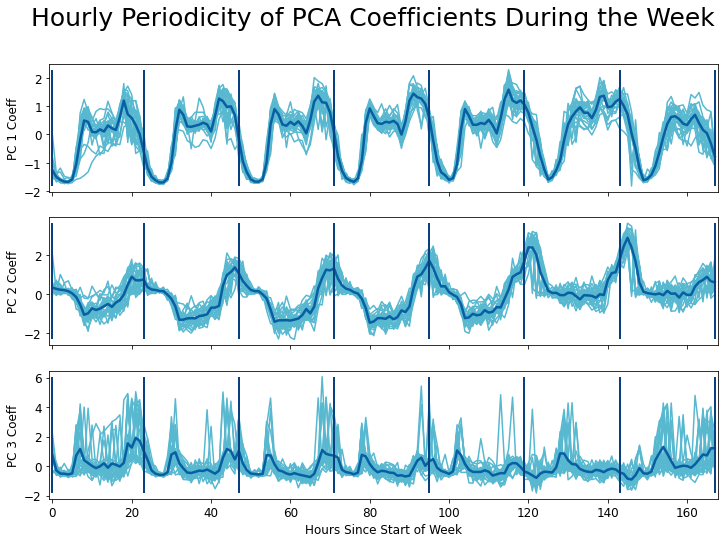

CPU times: user 1.39 s, sys: 473 ms, total: 1.86 s
Wall time: 1.09 s


In [38]:
%%time

# Collect traces for all weeks of the year
list_of_full_weeks = []
for unique_val in np.unique(week_of_year_vec):
    if (week_of_year_vec == unique_val).sum() == 24 * 7:
        list_of_full_weeks.append(unique_val)

# Initialize the matrix for weekly traces
weekly_traces = np.zeros((24 * 7, num_components, len(list_of_full_weeks)))

# Populate weekly traces
for k, week_ind in enumerate(list_of_full_weeks):
    weekly_traces[:, :, k] = compact_cluster_distribution_hour_of_year[week_of_year_vec == week_ind, :]

# Plotting PCA coefficients during the week
fig, ax_array = plt.subplots(nrows=num_components, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle("Hourly Periodicity of PCA Coefficients During the Week", fontsize=25)

# Plot each PCA component's trace
for pc_coeff in range(num_components):
    mean_trace = weekly_traces[:, pc_coeff, :].mean(axis=1)
    ax_array[pc_coeff].plot(weekly_traces[:, pc_coeff, :], color=gnbu_cmap(0.6), linewidth=1.5)
    ax_array[pc_coeff].plot(mean_trace, color=gnbu_cmap(0.9), linewidth=2.5)
    ax_array[pc_coeff].set_ylabel(f"PC {pc_coeff + 1} Coeff")
    
    # Mark the start of each day of the week (0-23, 24-47, etc.)
    ax_array[pc_coeff].vlines([0, 23, 47, 71, 95, 119, 143, 167], 
                               weekly_traces[:, pc_coeff, :].min(), 
                               weekly_traces[:, pc_coeff, :].max(), 
                               colors=gnbu_cmap(1.0), lw=2)

# Set x-axis labels and limits
ax_array[pc_coeff].set_xlabel("Hours Since Start of Week")
ax_array[pc_coeff].set_xlim(-0.9, 24 * 7 - 0.1)

# Save figure
plt.savefig("images/trip_pca_hourly_week_periodicity.png", dpi=300, bbox_inches="tight")

plt.show()

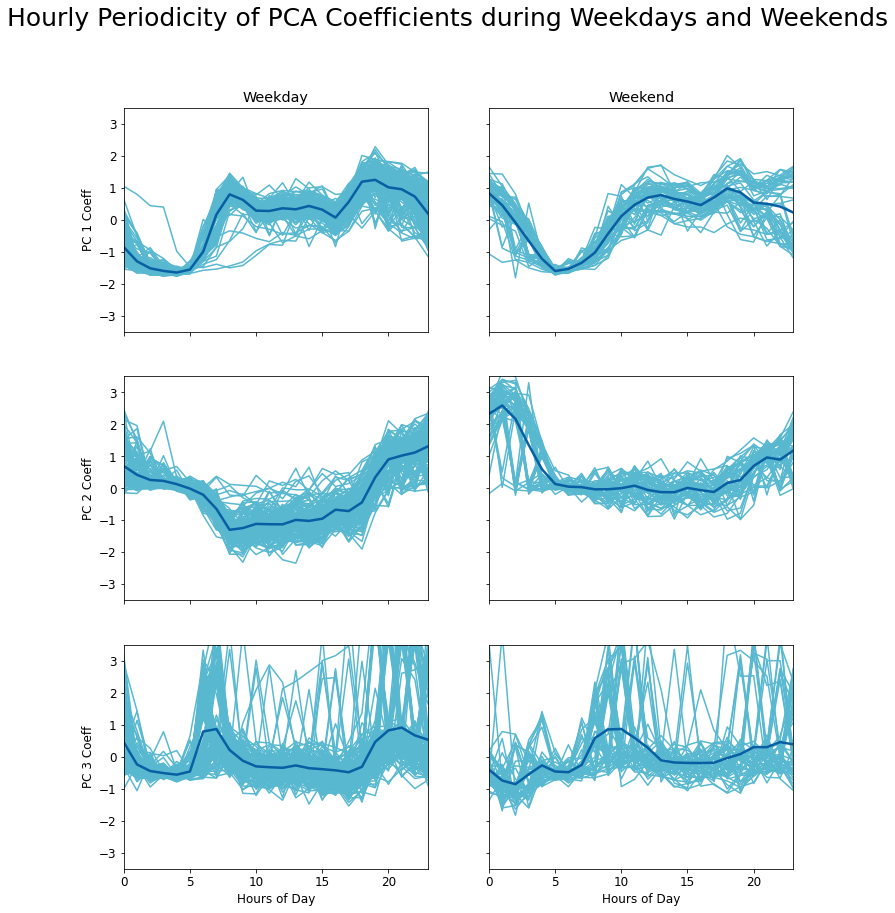

CPU times: user 2.45 s, sys: 256 ms, total: 2.71 s
Wall time: 2.34 s


In [39]:
%%time

# Collect traces for weekdays and weekends
list_of_full_weekdays = []
list_of_full_weekends = []

# Identify full weekdays and weekends
for unique_val in np.unique(day_of_year_vec):
    if (day_of_year_vec == unique_val).sum() == 24:
        if day_of_week_vec[day_of_year_vec == unique_val][0] <= 4:  # Weekdays (Mon-Fri)
            list_of_full_weekdays.append(unique_val)
        else:  # Weekends (Sat-Sun)
            list_of_full_weekends.append(unique_val)

# Initialize the matrices for weekday and weekend traces
weekday_traces = np.zeros((24, num_components, len(list_of_full_weekdays)))
weekend_traces = np.zeros((24, num_components, len(list_of_full_weekends)))

# Populate weekday traces
for k, day_ind in enumerate(list_of_full_weekdays):
    weekday_traces[:, :, k] = compact_cluster_distribution_hour_of_year[day_of_year_vec == day_ind, :]

# Populate weekend traces
for k, day_ind in enumerate(list_of_full_weekends):
    weekend_traces[:, :, k] = compact_cluster_distribution_hour_of_year[day_of_year_vec == day_ind, :]

# Plotting PCA coefficients for weekdays and weekends
fig, ax_array = plt.subplots(nrows=num_components, ncols=2, sharex=True, sharey=True, figsize=(12, 14))
fig.suptitle("Hourly Periodicity of PCA Coefficients during Weekdays and Weekends", fontsize=25)

# Plot each PCA component's trace for weekdays and weekends
for pc_coeff in range(num_components):
    # Weekday traces
    ax_array[pc_coeff][0].plot(weekday_traces[:, pc_coeff, :], color=gnbu_cmap(0.6), linewidth=1.5)  # Lighter blue
    ax_array[pc_coeff][0].plot(weekday_traces[:, pc_coeff, :].mean(axis=1), color=gnbu_cmap(0.9), linewidth=2.5)  # Darker blue
    ax_array[pc_coeff][0].set_ylabel(f'PC {pc_coeff + 1} Coeff')

    # Weekend traces
    ax_array[pc_coeff][1].plot(weekend_traces[:, pc_coeff, :], color=gnbu_cmap(0.6), linewidth=1.5)  # Lighter blue
    ax_array[pc_coeff][1].plot(weekend_traces[:, pc_coeff, :].mean(axis=1), color=gnbu_cmap(0.9), linewidth=2.5)  # Darker blue
    
    if pc_coeff == 0:
        ax_array[pc_coeff][0].set_title("Weekday")
        ax_array[pc_coeff][1].set_title("Weekend")

# Set x-axis and y-axis labels and limits
ax_array[pc_coeff][0].set_xlabel("Hours of Day")
ax_array[pc_coeff][1].set_xlabel("Hours of Day")
ax_array[pc_coeff][0].set_xlim(0, 23)
ax_array[pc_coeff][0].set_ylim(-3.5, 3.5)

# Save figure
plt.savefig("images/trip_pca_hourly_weekdays_weekends_periodicity.png", dpi=300, bbox_inches="tight")

plt.show()

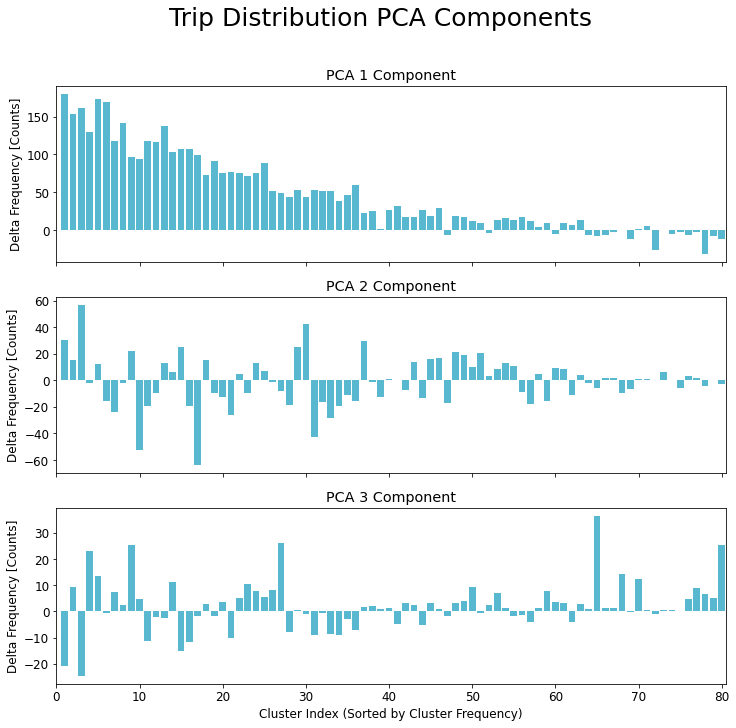

CPU times: user 1.29 s, sys: 195 ms, total: 1.48 s
Wall time: 1.29 s


In [40]:
%%time

# Examine what different PC coefficients mean by looking at their trip template distributions
fig, ax_array = plt.subplots(nrows=num_components, ncols=1, sharex=True, figsize=(12, 11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)

# Plot the trip template distribution differences for each PCA component
for pc_coeff in range(num_components):
    trip_template_distribution_difference = trip_distribution_pca_model.components_[pc_coeff, :] * \
                                            trip_distribution_pca_model.explained_variance_[pc_coeff]
    ax_array[pc_coeff].bar(range(1, num_clusters + 1), trip_template_distribution_difference, color=gnbu_cmap(0.6))
    ax_array[pc_coeff].set_title(f"PCA {pc_coeff + 1} Component")
    ax_array[pc_coeff].set_ylabel("Delta Frequency [Counts]")

# Set common axis labels and limits
ax_array[pc_coeff].set_xlabel("Cluster Index (Sorted by Cluster Frequency)")
ax_array[pc_coeff].set_xlim(0, num_clusters + 0.5)

# Add horizontal lines to mark specific thresholds (e.g., -25, 25 for the first component)
# ax_array[1].hlines([-25, 25], 0, num_clusters + 0.5, colors='r', lw=0.7)
# ax_array[2].hlines([-11, 11], 0, num_clusters + 0.5, colors='r', lw=0.7)

plt.show()

The PCA analysis shows three distinct patterns:
- **PCA Coefficient 1** represents the overall trip duration, capturing the general variation in travel times.
- **PCA Coefficient 2** identifies night patterns, emphasizing the surge in trips related to nightlife on weekends, particularly between 0 and 4 am.
- **PCA Coefficient 3** focuses on the morning pattern, highlighting weekday peak hours and late mornings during weekends, when travel behaviors differ.

### PCA Coefficient 2 Large Deviating Trips

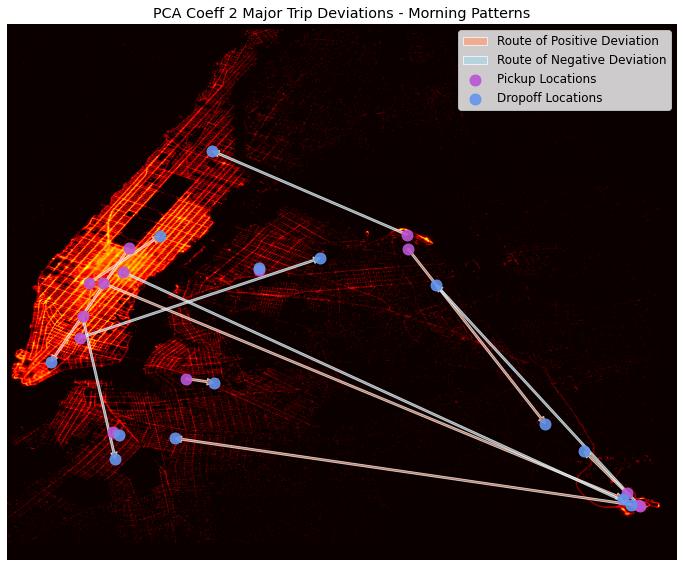

CPU times: user 384 ms, sys: 84.2 ms, total: 468 ms
Wall time: 287 ms


In [41]:
%%time

# Put the large deviating trips of each component back on the map
numTopTripsToShow = 8
numBottomTripsToShow = 6

# Meaning of 2nd PC
sorted_trip_clusters_PC2 = np.argsort(trip_distribution_pca_model.components_[1, :])
top_positive_trip_cluster_inds = sorted_trip_clusters_PC2[-numTopTripsToShow:]
top_negative_trip_cluster_inds = sorted_trip_clusters_PC2[:numBottomTripsToShow]
all_inds = np.hstack((top_positive_trip_cluster_inds, top_negative_trip_cluster_inds))

plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image + 1), cmap="hot")

# Draw arrows for major deviations
flag = True
for i in top_positive_trip_cluster_inds:
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="white", facecolor="lightsalmon", width=2.8, alpha=0.7,
              head_width=10.0, head_length=10.0, length_includes_head=True,
              label="Route of Positive Deviation" if flag else None)
    flag = False

flag = True
for i in top_negative_trip_cluster_inds:
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="white", facecolor="lightblue", width=2.8, alpha=0.7,
              head_width=10.0, head_length=10.0, length_includes_head=True,
              label="Route of Negative Deviation" if flag else None)
    flag = False

# Highlight pickup and dropoff locations
plt.scatter(src_im_coords[1][all_inds], src_im_coords[0][all_inds],
            c="mediumorchid", s=120, alpha=0.9, label="Pickup Locations")
plt.scatter(dst_im_coords[1][all_inds], dst_im_coords[0][all_inds],
            c="cornflowerblue", s=120, alpha=0.9, label="Dropoff Locations")

# Ensure no axis and grid
plt.grid(False)
plt.axis("off")

# Add title and display the plot
plt.title("PCA Coeff 2 Major Trip Deviations - Morning Patterns")
plt.legend(loc="upper right", fontsize=12)

plt.show()

### PCA Coefficient 3 Large Deviating Trips

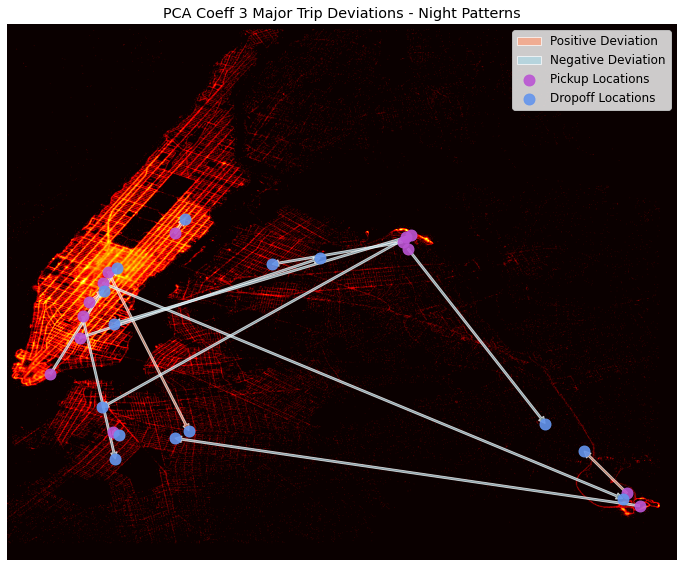

CPU times: user 367 ms, sys: 86.1 ms, total: 453 ms
Wall time: 271 ms


In [42]:
%%time

# Put the large deviating trips of each component back on the map
numTopTripsToShow = 4
numBottomTripsToShow = 10

# Meaning of 3rd PC (coeff 2 is now coeff 3)
sorted_trip_clusters_PC3 = np.argsort(trip_distribution_pca_model.components_[2, :])
top_positive_trip_cluster_inds = sorted_trip_clusters_PC3[-numTopTripsToShow:]
top_negative_trip_cluster_inds = sorted_trip_clusters_PC3[:numBottomTripsToShow:]
all_inds = np.hstack((top_positive_trip_cluster_inds, top_negative_trip_cluster_inds))

plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image + 1), cmap="hot")

# Draw arrows for major deviations
flag = True
for i in top_positive_trip_cluster_inds:
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="white", facecolor="lightsalmon", width=2.8, alpha=0.7,
              head_width=10.0, head_length=10.0, length_includes_head=True,
              label="Positive Deviation" if flag else None)
    flag = False

flag = True
for i in top_negative_trip_cluster_inds:
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="white", facecolor="lightblue", width=2.8, alpha=0.7,
              head_width=10.0, head_length=10.0, length_includes_head=True,
              label="Negative Deviation" if flag else None)
    flag = False

# Highlight pickup and dropoff locations
plt.scatter(src_im_coords[1][all_inds], src_im_coords[0][all_inds],
            c="mediumorchid", s=120, alpha=0.9, label="Pickup Locations")
plt.scatter(dst_im_coords[1][all_inds], dst_im_coords[0][all_inds],
            c="cornflowerblue", s=120, alpha=0.9, label="Dropoff Locations")

# Ensure no axis and grid
plt.grid(False)
plt.axis("off")

# Add title and display the plot
plt.title("PCA Coeff 3 Major Trip Deviations - Night Patterns")
plt.legend(loc="upper right", fontsize=12)

plt.show()

---